#### TEXT CLASSIFIERS - SUPERVISED METHODS

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import sre_yield
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn import svm

from sklearn.metrics import accuracy_score


**STEPS:**

- select records without garbage codes to train and test models - DONE
- create labels for records (10 leading causes of death) by grouping ICD-10 codes - DONE
- label records - DONE
- preprocess text and ICD-10 codes - DONE
- train models
    - Linear SVM
    - logistic regression
    - Naive Bayes
- compare accuracy and select best model
- train, test
- apply to garbage code records
    - does this need to be done separately for each gc category? OR
    - remove labels if target category is implausible or impossible"
- compare classification with LDA
    



In [2]:
death_df = pd.read_csv('Y:/DQSS/Death/MBG/py/capstone2/data/d1619_gclabelled.csv',
                       dtype={'MC1':str,'MC2':str,'MC3':str,'MC4':str,'MC5':str,'MC6':str,
                             'MC7':str,'MC8':str,'MC9':str,'MC10':str,'MC11':str,'MC12':str,
                             'MC13':str,'MC14':str,'MC15':str,'MC16':str,'MC17':str,'MC18':str,
                             'MC19':str,'MC20':str},
                       low_memory=False,
                       encoding = 'unicode_escape')

In [3]:
death_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226996 entries, 0 to 226995
Data columns (total 49 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    226996 non-null  int64  
 1   sfn           226996 non-null  int64  
 2   sex           226996 non-null  object 
 3   ageyrs        226996 non-null  float64
 4   dod           226996 non-null  object 
 5   dody          226996 non-null  int64  
 6   dcounty       226995 non-null  object 
 7   dstateFIPS    226996 non-null  object 
 8   bridgerace    226996 non-null  int64  
 9   hispno        226996 non-null  object 
 10  marital       226996 non-null  object 
 11  rstatefips    226996 non-null  object 
 12  manner        226954 non-null  object 
 13  tobac         226996 non-null  object 
 14  pg            166760 non-null  float64
 15  certdesig     225382 non-null  float64
 16  UCOD          226841 non-null  object 
 17  MC1           226825 non-null  object 
 18  MC2 

In [4]:
death_df.gc_cat_label.value_counts()

0-No GC                         211923
6-Ill-defined cardiovascular      3868
5-Ill-defined                     2973
2-Heart failure                   2767
3-Ill-defined cancer              2376
1-Septicemia                      2149
4-Volume depletion                 534
8-Undetermined intent              368
9-Ill-defined infectious            38
Name: gc_cat_label, dtype: int64

In [5]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', None)

In [6]:
death_df.head()

,Unnamed: 0,sfn,sex,ageyrs,dod,dody,dcounty,dstateFIPS,bridgerace,hispno,marital,rstatefips,manner,tobac,pg,certdesig,UCOD,MC1,MC2,MC3,MC4,MC5,MC6,MC7,MC8,MC9,MC10,MC11,MC12,MC13,MC14,MC15,MC16,MC17,MC18,MC19,MC20,codAq,codBq,codCq,codDq,codIIq,AllMC,codlit,gc_any,gc_cat,gc_cat_label,agegrp,cert_label
0,0,2017019369,F,81.0,2017-04-12,2017,PIERCE,WA,1,Y,M,WA,N,N,8.0,1.0,I500,I500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PROBABLE CONGESTIVE HEART FAILURE,NaN,NaN,NaN,HOSPICE,I500,PROBABLE CONGESTIVE HEART FAILURE HOSPICE,True,2,2-Heart failure,80+ yrs,1-Physician
1,1,2017019370,F,87.0,2017-04-23,2017,THURSTON,WA,1,Y,M,WA,N,N,8.0,1.0,I219,I219,I10,I259,I490,I739,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,VENTRICULAR FIBRILLATION,ACUTE MYOCARDIAL INFARCTION,CORONARY HEART DISEASE,NaN,"HYPERTENSION, PERIPHERAL VASCULAR DISEASE",I219 I10 I259 I490 I739,VENTRICULAR FIBRILLATION ACUTE MYOCARDIAL INFA...,False,0,0-No GC,80+ yrs,1-Physician
2,2,2019039107,F,85.0,2019-08-31,2019,SPOKANE,WA,1,Y,D,WA,N,U,8.0,1.0,G309,G309,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ALZHEIMER'S DEMENTIA,NaN,NaN,NaN,NaN,G309,ALZHEIMER'S DEMENTIA,False,0,0-No GC,80+ yrs,1-Physician
3,3,2019033199,M,41.0,2019-07-23,2019,KING,WA,8,Y,S,CA,A,N,8.0,2.0,X41,X41,T436,T509,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ACUTE METHAMPHETAMINE INTOXICATION,NaN,NaN,NaN,NaN,X41 T436 T509,ACUTE METHAMPHETAMINE INTOXICATION TOXIC U...,False,0,0-No GC,40-49 yrs,2-ME/Coroner
4,4,2019041162,M,69.0,2019-09-16,2019,SNOHOMISH,WA,1,Y,M,WA,N,Y,8.0,1.0,C099,C099,E119,F101,F179,I251,I99,J958,J969,T814,Y839,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RESPIRATORY FAILURE,SEPSIS AND PNEUMONIA,STATUS POST THROAT SURGERY,SQUAMOUS CARCINOMA OF RIGHT TONSIL,"SMOKER, ALCOHOL ABUSE, CORONARY ARTERY DISEASE...",C099 E119 F101 F179 I251 I99 J958 J969 T814 Y8...,RESPIRATORY FAILURE SEPSIS AND PNEUMONIA STATU...,False,0,0-No GC,60-69 yrs,1-Physician


**Keep relevant variables**

In [7]:
df = death_df.loc[: , ['sex','manner', 'tobac', 'codlit', 'UCOD', 'MC2','MC3','MC4','MC5','MC6','MC7','MC8','MC9',
                'MC10','MC11','MC12','MC13','MC14','MC15','MC16','MC17','MC18','MC19',
                'MC20','AllMC','gc_cat', 'gc_cat_label', 'agegrp']]

In [8]:
mcvars = ['MC2','MC3','MC4','MC5','MC6','MC7','MC8','MC9','MC10','MC11','MC12','MC13','MC14',
          'MC15','MC16','MC17','MC18','MC19', 'MC20']

df['mc2_20'] = df[mcvars].apply(lambda x: ' '.join(x.dropna()), axis=1)

df.head()

,sex,manner,tobac,codlit,UCOD,MC2,MC3,MC4,MC5,MC6,MC7,MC8,MC9,MC10,MC11,MC12,MC13,MC14,MC15,MC16,MC17,MC18,MC19,MC20,AllMC,gc_cat,gc_cat_label,agegrp,mc2_20
0,F,N,N,PROBABLE CONGESTIVE HEART FAILURE HOSPICE,I500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,I500,2,2-Heart failure,80+ yrs,
1,F,N,N,VENTRICULAR FIBRILLATION ACUTE MYOCARDIAL INFA...,I219,I10,I259,I490,I739,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,I219 I10 I259 I490 I739,0,0-No GC,80+ yrs,I10 I259 I490 I739
2,F,N,U,ALZHEIMER'S DEMENTIA,G309,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G309,0,0-No GC,80+ yrs,
3,M,A,N,ACUTE METHAMPHETAMINE INTOXICATION TOXIC U...,X41,T436,T509,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,X41 T436 T509,0,0-No GC,40-49 yrs,T436 T509
4,M,N,Y,RESPIRATORY FAILURE SEPSIS AND PNEUMONIA STATU...,C099,E119,F101,F179,I251,I99,J958,J969,T814,Y839,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C099 E119 F101 F179 I251 I99 J958 J969 T814 Y8...,0,0-No GC,60-69 yrs,E119 F101 F179 I251 I99 J958 J969 T814 Y839


In [9]:
len(df)

226996

**ATTACHING LABELS** The data frame consists of records with non-garbage underlying cause codes.  ICD-10 codes in the underlying cause variable are typically grouped together to more meaningful categories that are used to understand mortality patterns.  For example, while lung cancer deaths are assigned a code between C34.0 and C34.9 (based on the specific location of the cancer), typically, leading cause of death analyses will group deaths due to any cancer into the "malignant neoplasm" category which contains all codes from C00.0 through C97.9.

In the next step, all deaths in the data frame will be labeled with one of ten causes of death that are leading causes in Washington State (and most of the United States). Together, these ten causes account for ___ % of all deaths in the state.  It is very likely that the poorly coded records will belong to one of these groups.

In [10]:

# all cancer (C00–C97)
cancer = []

for code in sre_yield.AllStrings(r'^C[0-8][0-9][0-9]{0,1}'):
    cancer.append(code)
    
for code in sre_yield.AllStrings(r'^C9[0-7][0-9]{0,1}'):
    cancer.append(code)

# all heart disease (I00–I09,I11,I13,I20–I51)
 
heart_disease = []

for code in sre_yield.AllStrings(r'^I[00][0-9][0-9]{0,1}'):
    heart_disease.append(code)

for code in sre_yield.AllStrings(r'^I13[0-9]{0,1}'):
    heart_disease.append(code)

for code in sre_yield.AllStrings(r'^I[2-4][0-9][0-9]{0,1}'):
    heart_disease.append(code)

for code in sre_yield.AllStrings(r'^I51[0-9]{0.1}'):
    heart_disease.append(code)

# Cerebrovasular disease  (I60–I69)

cerebrovascular_disease = []

for code in sre_yield.AllStrings(r'^I6[0-9][0-9]{0,1}'):
    cerebrovascular_disease.append(code)

# Diabetes (E10–E14)

diabetes = []

for code in sre_yield.AllStrings(r'^E1[0-4][0-9]{0,1}'):
    diabetes.append(code)
    
# Alzheimer's disease(G30)
                                 
alzheimers = []

for code in sre_yield.AllStrings(r'^G30[0,1,8,9]{0,1}'):
    alzheimers.append(code)
    
# Influenza and Pneumonia (J09–J18)
    
flu_pneumonia = []

for code in sre_yield.AllStrings(r'^J09[0-1]{0,1}'):
    flu_pneumonia.append(code)
    
for code in sre_yield.AllStrings(r'^J1[0-8][0-9]{0,1}'):
    flu_pneumonia.append(code)
    
    
# chronic lower respiratory disease (J40–J47)

clrd = []

for code in sre_yield.AllStrings(r'^J4[0-7][0-9]{0,1}'):
    clrd.append(code)
    
# Chronic liver disease and cirrhosis (K70,K73–K74)    

liver_dis = []

for code in sre_yield.AllStrings(r'^K70[0-9]{0,1}'):
    liver_dis.append(code)

for code in sre_yield.AllStrings(r'^K7[3-4][0-9]{0,1}'):
    liver_dis.append(code)
        
# Suicide (*U03,X60–X84,Y87.0)
suicide = []

for code in sre_yield.AllStrings(r'^U03(0-9)?'):
    suicide.append(code)

for code in sre_yield.AllStrings(r'^X[6-7][0-9](0-9)?'):
    suicide.append(code)
    
for code in sre_yield.AllStrings(r'^X8[0-4](0-9)?'):
    suicide.append(code)
    
for code in sre_yield.AllStrings(r'^Y870'):
    suicide.append(code)     
                                 

#Unintentional injury (V01–X59,Y85–Y86)

accident = []

for code in sre_yield.AllStrings(r'^V[0-9][0-9](0-9)?'):
    accident.append(code)
    
for code in sre_yield.AllStrings(r'^W[0-9][0-0](0-9)?'):
    accident.append(code)

for code in sre_yield.AllStrings(r'^X[0-5][0-9](0-9)?'):
    accident.append(code)    

        

In [11]:
leading_cause_dict = {1: cancer,
                      2: heart_disease,
                      3: cerebrovascular_disease,
                      4: diabetes,
                      5: alzheimers,
                      6: flu_pneumonia,
                      7: clrd,
                      8: liver_dis,
                      9: suicide,
                      10: accident
                     }

In [12]:
lcod_dict_rev = {v: k for k in leading_cause_dict for v in leading_cause_dict[k]}

#the above is functional equivalent of:
#lcod_dict_rev = {}
#for key in leading_cause_dict:
#    for value in leading_cause_dict[key]:
#        gcdict_rev[value] = key

In [13]:
lcod_label_dict = {1: 'Cancer',
                   2: 'Heart disease',
                   3: 'Cerebrovascular disease',
                   4: 'Diabetes',
                   5: 'Alzheimers',
                   6: 'Influenza pneumonia',
                   7: 'Chronic lower resp. dis.',
                   8: 'Liver disease',
                   9: 'Suicide',
                   10: 'Unintentional injury',
                   11: 'Other'}

In [14]:
df['leading_cause'] = df['UCOD'].map(lcod_dict_rev).fillna(11).astype(int)
df['lcod_labels'] = df['leading_cause'].map(lcod_label_dict)  

In [15]:
df.lcod_labels.value_counts()

Other                       73297
Cancer                      51256
Heart disease               38612
Alzheimers                  14522
Chronic lower resp. dis.    12287
Cerebrovascular disease     11893
Diabetes                     7141
Unintentional injury         5372
Suicide                      4969
Liver disease                3982
Influenza pneumonia          3665
Name: lcod_labels, dtype: int64

In [16]:
round(df.lcod_labels.value_counts(normalize=True)*100,1)

Other                       32.3
Cancer                      22.6
Heart disease               17.0
Alzheimers                   6.4
Chronic lower resp. dis.     5.4
Cerebrovascular disease      5.2
Diabetes                     3.1
Unintentional injury         2.4
Suicide                      2.2
Liver disease                1.8
Influenza pneumonia          1.6
Name: lcod_labels, dtype: float64

In [17]:
df.gc_cat_label.value_counts()

0-No GC                         211923
6-Ill-defined cardiovascular      3868
5-Ill-defined                     2973
2-Heart failure                   2767
3-Ill-defined cancer              2376
1-Septicemia                      2149
4-Volume depletion                 534
8-Undetermined intent              368
9-Ill-defined infectious            38
Name: gc_cat_label, dtype: int64

**Remove rows with missing values in MC2 - MC20** as these will not contribute much when training supervised models.

In [18]:
df.dropna(subset = ["MC2"], inplace=True)
len(df)

188306

In [19]:
df.head()

,sex,manner,tobac,codlit,UCOD,MC2,MC3,MC4,MC5,MC6,MC7,MC8,MC9,MC10,MC11,MC12,MC13,MC14,MC15,MC16,MC17,MC18,MC19,MC20,AllMC,gc_cat,gc_cat_label,agegrp,mc2_20,leading_cause,lcod_labels
1,F,N,N,VENTRICULAR FIBRILLATION ACUTE MYOCARDIAL INFA...,I219,I10,I259,I490,I739,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,I219 I10 I259 I490 I739,0,0-No GC,80+ yrs,I10 I259 I490 I739,2,Heart disease
3,M,A,N,ACUTE METHAMPHETAMINE INTOXICATION TOXIC U...,X41,T436,T509,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,X41 T436 T509,0,0-No GC,40-49 yrs,T436 T509,10,Unintentional injury
4,M,N,Y,RESPIRATORY FAILURE SEPSIS AND PNEUMONIA STATU...,C099,E119,F101,F179,I251,I99,J958,J969,T814,Y839,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C099 E119 F101 F179 I251 I99 J958 J969 T814 Y8...,0,0-No GC,60-69 yrs,E119 F101 F179 I251 I99 J958 J969 T814 Y839,1,Cancer
5,M,N,N,EMBOLIC STROKE HYPERCOAGULABLE STATE NON SMALL...,I634,C349,C831,D689,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,I634 C349 C831 D689,0,0-No GC,60-69 yrs,C349 C831 D689,3,Cerebrovascular disease
6,M,N,N,CARDIOPULMONARY ARREST HYDROCEPHALUS AND STATU...,G919,D429,G419,I469,I500,I64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G919 D429 G419 I469 I500 I64,0,0-No GC,50-59 yrs,D429 G419 I469 I500 I64,11,Other


The dataframe originally consisted of 226,996 records but after removing rows with missing values in these multiple cause fields the dataset is reduced to 177,362 rows. This means that for the dropped rows the medical certifier reported only one condition leading to the cause of death.

**PREPROCESS CAUSE OF DEATH ICD 10 CODE FIELDS**

In [20]:
## call stored object 'gc_all' created in 2_PrepData_ICD10.ipynb.
%store -r gc_all 
%store -r g3

In [21]:
#cancer_gcs = '|'.join(g3)
#mask = df['mc2_20'].str.contains(cancer_gcs)
#cancer_df = df.loc[mask, : ]
#cancer_df = cancer_df.loc[cancer_df['lcod_labels']=='Cancer', ['lcod_labels', 'mc2_20', 'gc_cat', 'gc_cat_label', 'UCOD', 'agegrp', 'sex', 'tobac','manner']]

In [22]:
#cancer_df.head(10)

In [23]:
#len(cancer_df)

In [24]:
# Keep records with valid underlying cause code and selected variables

selectedcols = ['lcod_labels', 'AllMC','mc2_20', 'agegrp', 'sex', 'tobac','manner']
df = df.loc[df['gc_cat']==0, selectedcols]

In [25]:
df['lcod_id'] = df['lcod_labels'].factorize()[0]

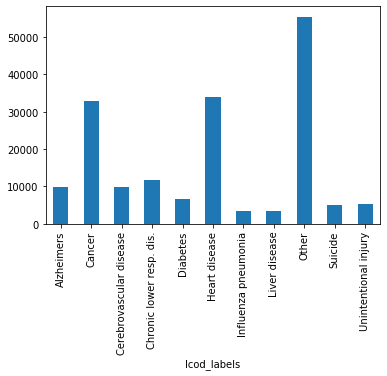

In [26]:
df.groupby('lcod_labels').lcod_id.count().plot.bar(ylim=0)
plt.show()

**Cancer and heart disease deaths dominate** in the dataset of records with valid (non-garbage) underlying cause codes.  Chronic lower respiratory disease, Alzheimer's disease, and cerebrovascular disease are also among the top five most common causes of death in Washington State in this period. The catchall category of 'Other' causes of death encompasses a variety of diseases and conditions that together account for 31% of the deaths. 

In [27]:
## call stored object 'gc_all' created in 2_PrepData_ICD10.ipynb.
%store -r gc_all  

In [28]:
#vectorize ICD-10 codes with tf-idf including all garbage codes

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=100, lowercase=False, ngram_range=(1, 2))

features = tfidf.fit_transform(df.mc2_20).toarray()
labels = df.lcod_id
features.shape

(177362, 983)

In [29]:
#create dictionaries

lcod_df = df[[ 'lcod_labels','lcod_id']].drop_duplicates().sort_values('lcod_id')
cause_to_id = dict(lcod_df.values)
id_to_cause = dict(lcod_df[['lcod_id', 'lcod_labels']].values)


**CHI SQUARE ANALYSIS TO EXAMINE CORRELATION BETWEEN ICD-10 CODES (UNIGRAMS AND BIGRAMS) AND LEADING CAUSE OF DEATH CATEGORIES**

In [30]:
# find ICD 10 codes most correlated with each cause of death

from sklearn.feature_selection import chi2

N=2
for lcod_labels, lcod_id in sorted(cause_to_id.items()):
    features_chi2 = chi2(features, labels == lcod_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) ==1]
    bigrams = [v for v in feature_names if len(v.split(' '))==2]
    print("## '{}':".format(lcod_labels))
    print(" **Most correlated UNIGRAMS: \n. {}".format('\n.'.join(unigrams[-N:])))
    print(" **Most correlated BIGRAMS: \n. {}".format('\n.'.join(bigrams[-N:])))


## 'Alzheimers':
 **Most correlated UNIGRAMS: 
. R53
.R628
 **Most correlated BIGRAMS: 
. J961 R092
.J690 R13
## 'Cancer':
 **Most correlated UNIGRAMS: 
. C787
.F179
 **Most correlated BIGRAMS: 
. C787 C795
.C780 C787
## 'Cerebrovascular disease':
 **Most correlated UNIGRAMS: 
. G935
.I10
 **Most correlated BIGRAMS: 
. I10 I48
.G935 I10
## 'Chronic lower resp. dis.':
 **Most correlated UNIGRAMS: 
. J961
.F179
 **Most correlated BIGRAMS: 
. F179 J960
.F179 J969
## 'Diabetes':
 **Most correlated UNIGRAMS: 
. I251
.I219
 **Most correlated BIGRAMS: 
. I219 I251
.I10 I219
## 'Heart disease':
 **Most correlated UNIGRAMS: 
. R570
.I500
 **Most correlated BIGRAMS: 
. I500 J449
.I48 I500
## 'Influenza pneumonia':
 **Most correlated UNIGRAMS: 
. J80
.A419
 **Most correlated BIGRAMS: 
. J80 J960
.A419 J960
## 'Liver disease':
 **Most correlated UNIGRAMS: 
. K767
.K729
 **Most correlated BIGRAMS: 
. J969 K729
.K729 N179
## 'Other':
 **Most correlated UNIGRAMS: 
. S099
.F179
 **Most correlated BIGR

Based on initial examination, there appears to be good correlation between ICD-10 code and leading cause of death.  The ICD-10 code unigrams and bigrams are appropriately matched to each of the cause of death categories.

#### Multnomial Naive Bayes Classifier

The text data used to train this classifier is in the column called "mc2_20" which consists of a concatenation of all ICD-10 codes in positions MC2 through MC20.  'mc2_20' does not include MC1 which is always populated with the underlying cause ICD-10 code.  The reason for excluding the underlying cause code is to see how well the remaining multiple cause codes can predict the leading cause of death category to which the observation belongs. Providing MC1 to train the model would be similar to providing the labels as one of the training features.

In [31]:
# train MNB model and predict labels in test data

Xtrain, Xtest, ytrain, ytest = train_test_split(df['mc2_20'],df['lcod_id'], 
                                                test_size=0.3, 
                                                random_state = 77)


tfidf_vect = TfidfVectorizer(sublinear_tf=True, min_df=100, lowercase=False, ngram_range=(1, 2))
tfidf_vect.fit(df['mc2_20'])

X_train_tfidf = tfidf_vect.transform(Xtrain)
X_test_tfidf = tfidf_vect.transform(Xtest)

mnb = MultinomialNB()
mnb_clf = mnb.fit(X_train_tfidf, ytrain)

ypred = mnb_clf.predict(X_test_tfidf)

In [32]:
# check accuracy of MNB model

print('Multinomial Naive Bayes classifier accuracy:', 
      round(accuracy_score(ytest, ypred)*100,1),'%')

Multinomial Naive Bayes classifier accuracy: 53.8 %


Multnimoial Naive Bayes classifier only had an accuracy of 53.8% in classifying records based on muliple cause codes into one of 10 cause of death groups.

#### Linear Support Vector Machine

Linear support vector classifier
- garbage codes left intact
- all cause of death categories

In [33]:
## Algorithm: Support Vector Machine

lin_svc = svm.LinearSVC()
lin_svc.fit(X_train_tfidf, ytrain)

SVC_prediction = lin_svc.predict(X_test_tfidf)

In [34]:
print("SVM accuracy score:", round(accuracy_score(SVC_prediction, ytest)*100,1), "%")

SVM accuracy score: 55.5 %


The accuracy of support vector machine algorithm is not much better than the multinomial Naive Bayes model trained above to classify deaths into 10 cause of death groups.

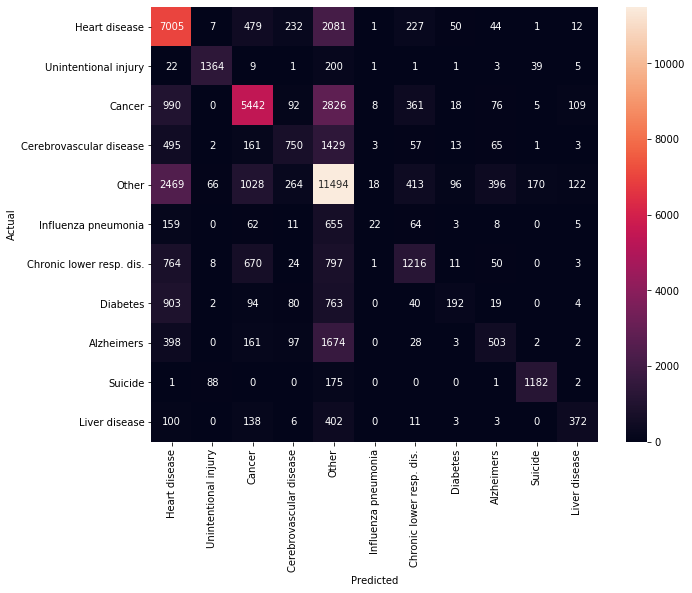

In [35]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(ytest, SVC_prediction)
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(conf_mat, annot=True, fmt='g',
           xticklabels = lcod_df.lcod_labels.values,
           yticklabels = lcod_df.lcod_labels.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


The confusion matrix suggests that when records are misclassified by this model they are more likely to be classified as 'other' especially when the true label is either 'cancer' or 'heart disease'.  Conversely, when the actual class is other, there is a high likelihood that the record will be misclassified as 'other'.

These results suggest that the 'other' category needs to be further broken out into additional cause of death groups or reapportioned to the remaining categories so that it isn't the largest single category of the ones listed in the heat map above.

**TRAINING A ONE VS. ALL CLASSIFIER FOR EACH OF THE 5 LEADING CAUSES OF DEATH**

In the previous attempts, the algorithms were trained as multi-class text classifiers.  In the following attempts I will build a 'one vs. all' approach with both Multinomial Naive Bayes and SVM models using two classes only.  The classes will be the selected leading cause vs. all other causes of deaths.  Again, no garbage codes will be removed in the first attempt.

In [36]:
def classify_oneVall(df):
    
    Lcods = ['Cancer','Heart disease','Alzheimers','Cerebrovascular disease', 'Diabetes', 'Chronic lower resp. dis.']
    Models = [MultinomialNB, LinearSVC]
    
    for lcod in Lcods:
  
        df[lcod] = 0
        df.loc[df['lcod_labels']==lcod, lcod]=1
    
        TrainX, TestX, train_y, test_y = train_test_split(df['mc2_20'], df[lcod],
                                                                           test_size=0.3,
                                                                           random_state=7)
        tfidf_vect = TfidfVectorizer(sublinear_tf=True,
                                         min_df=10, 
                                         lowercase=False, 
                                         ngram_range=(1, 2))
            
        tfidf_vect.fit(df['mc2_20'])
        TrainX_tfidf = tfidf_vect.transform(TrainX)
        TestX_tfidf = tfidf_vect.transform(TestX)
        
        for model in Models:          
            clf = model()
            clf.fit(TrainX_tfidf, train_y)

            pred_clf = clf.predict(TestX_tfidf)
            print("Accuracy score:", model, lcod, round(accuracy_score(pred_clf, test_y)*100,1), "%")


In [37]:
classify_oneVall(df)

Accuracy score: <class 'sklearn.naive_bayes.MultinomialNB'> Cancer 86.4 %
Accuracy score: <class 'sklearn.svm._classes.LinearSVC'> Cancer 87.3 %
Accuracy score: <class 'sklearn.naive_bayes.MultinomialNB'> Heart disease 84.7 %
Accuracy score: <class 'sklearn.svm._classes.LinearSVC'> Heart disease 85.1 %
Accuracy score: <class 'sklearn.naive_bayes.MultinomialNB'> Alzheimers 94.4 %
Accuracy score: <class 'sklearn.svm._classes.LinearSVC'> Alzheimers 94.6 %
Accuracy score: <class 'sklearn.naive_bayes.MultinomialNB'> Cerebrovascular disease 94.6 %
Accuracy score: <class 'sklearn.svm._classes.LinearSVC'> Cerebrovascular disease 94.7 %
Accuracy score: <class 'sklearn.naive_bayes.MultinomialNB'> Diabetes 96.3 %
Accuracy score: <class 'sklearn.svm._classes.LinearSVC'> Diabetes 96.3 %
Accuracy score: <class 'sklearn.naive_bayes.MultinomialNB'> Chronic lower resp. dis. 93.9 %
Accuracy score: <class 'sklearn.svm._classes.LinearSVC'> Chronic lower resp. dis. 94.0 %


Accuracy of the Naive Bayes model is vastly improved with a two group classifier.

SVM is also much improved - 87% accuracy.

**Retraining the two models using text data stripped of garbage codes**

In [39]:
df['cancer'] = 0
df.loc[df['lcod_labels']=="Cancer", 'cancer']=1
Xtrain_ca_nogc, Xtest_ca_nogc, ytrain_ca_nogc, ytest_ca_nogc = train_test_split(df['mc2_20'],
                                                                                df['cancer'], 
                                                test_size=0.3, 
                                                random_state = 77)


tfidf_vect_nogc = TfidfVectorizer(sublinear_tf=True, min_df=100, 
                             lowercase=False, 
                             ngram_range=(1, 2), 
                             stop_words=gc_all)  ##REMOVING ALL GARBAGE CODES

tfidf_vect_nogc.fit(df['mc2_20'])

Xtrain_tfidf_ca_nogc = tfidf_vect_nogc.transform(Xtrain_ca_nogc)
Xtest_tfidf_ca_nogc = tfidf_vect_nogc.transform(Xtest_ca_nogc)



In [40]:
mnb = MultinomialNB()
mnb_clf = mnb.fit(Xtrain_tfidf_ca_nogc, ytrain_ca_nogc)

MNBpred_ca_nogc = mnb_clf.predict(Xtest_tfidf_ca_nogc)

print("MNB accuracy score -no garbage codes in corpus - cancer (yes v. no):", 
      round(accuracy_score(MNBpred_ca_nogc, ytest_ca_nogc)*100,1), "%")

MNB accuracy score -no garbage codes in corpus - cancer (yes v. no): 85.7 %


In [43]:
lin_svc = svm.LinearSVC()
lin_svc.fit(Xtrain_tfidf_ca_nogc, ytrain_ca_nogc)
SVCpred_nogc_cancer = lin_svc.predict(Xtest_tfidf_ca_nogc)
print("SVM accuracy score - no garbage codes in corpus- cancer (yes v. no):", 
      round(accuracy_score(SVCpred_nogc_cancer, ytest_ca_nogc)*100,1), "%")


SVM accuracy score - no garbage codes in corpus- cancer (yes v. no): 85.9 %


It looks like both models performed slightly better when trained on a corpus containing the garbage codes. 

NEXT STEPS:

- grid search for best parameter values for SVM model along with cross validation
- use cause of death text instead of ICD-10 codes

**SVM grid search**

In [45]:
df['cancer'] = 0
df.loc[df['lcod_labels']=="Cancer", 'cancer']=1
    
TrainX, TestX, train_y, test_y = train_test_split(df['mc2_20'], df['cancer'],
                                                              test_size=0.3,
                                                             random_state=7)

tfidf_vect = TfidfVectorizer(sublinear_tf=True,
                                         min_df=10, 
                                         lowercase=False, 
                                         ngram_range=(1, 2))
            
tfidf_vect.fit(df['mc2_20'])
TrainX_tfidf = tfidf_vect.transform(TrainX)
TestX_tfidf = tfidf_vect.transform(TestX)
        

In [53]:
from sklearn.model_selection import GridSearchCV

def svc_param_selection(X, y):
    Cs = [0.001, 0.01, 0.1, 1 ,10]
    param_grid = {'C': Cs, }
    grid_search = GridSearchCV(LinearSVC(), param_grid, n_jobs=4, verbose=3)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

In [54]:
svc_param_selection(TrainX_tfidf, train_y)


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:   30.6s finished


{'C': 0.1}

The'C' parameter (regularization parameter) optimizes the SCM classifier by specifying the margin between the hyperplane and the support vectors.  A large value of C will choose smaller margins where as a small value of C will specify a larger margin in order to best classify the points correctly.

In this case grid searching yielded a C value of 0.1 (out of possible values of 0.001, 0.01, 0.1, 1, and 10).

The drawback of training these classifiers on data with valid underlying cause codes is that in general these records are more likely to contain meaningful codes (both underlying cause code and upto 19 additional multiple cause codes).  Records with garbage codes for underlying cause codes may not contain as much useful information in the multiple cause fields to allow accurate classification with a model trained on valid codes.

**NEXT STEPS**

- apply linear svc (with GC in corpus) to records with GC in underlying cause of death - to be done as two class problem with each of the five leading causes of death.

- comparison to LDA findings.